# Uploading Modules

In [1]:
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_md')
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Data

In [2]:
active20=pd.read_csv("active20-clean.csv")
active19=pd.read_csv("active19-clean.csv")
lazy20=pd.read_csv("lazy20-clean.csv")
lazy19=pd.read_csv("lazy19-clean.csv")
twitter_users = pd.read_csv("Twitter users.csv")

In this section we will try to answer the following questions:
- How much more people tweeted about diseases and being sick in 2020 vs 2019? Any difference between active and lazy user cohorts?
- What is the overall change in sentiment on disease-related tweets between 2019 vs 2020 and lazy vs active? <br>
To answer these questions, we will use topic classification. For this we will need to know the topics of a text before starting the analysis, because we will need to tag data in order to train a topic classifier. We will identify disease releated tweets using the concept of semantic similarity and SpaCy NLP package, and then analyze Twitter sentiment on disease-related tweets for 2019 vs 2020 and lazy vs active using vaderSentiment. 

## Tweets about COVID and Diseases

We will pick all the tweets that are semantically similar to Coronavirus-related words in 2020 or disease-related words in 2019 using the algorithm word2vec and spaCy's prebuilt word embeddings.<br> 
For our analysis we choose tweets with the similarity 0.55 or higher. (We intentionally set the threshold for similarity as high as 0.55 to ensure that only the relevant tweets will get selected. We wanted to avoid tweets like "This day was sick!" (i.e. great day))<br>
Also, after some consideration we decided to exlude the words "fever" and "emergency" from the disease-related words, because we wanted to avoid the mix up with the expression "cabin fever" and exclude tweets about natural disasters like fires and hurricanes (even though one can argue that these events also change the predictable course of life).

In [3]:
# Create a word embedding using spaCy for the Coronavirus-related words and disease-related words
covid = nlp('covid coronavirus virus pandemic disease lockdown quarantine cough doctor nurse hospital')
disease = nlp('disease virus cough doctor nurse hospital')

Now let's define semantic similarity to the covid word vector in 2020 and to the disease word vector in 2019.

In [4]:
import warnings
warnings.simplefilter("ignore", UserWarning)
active19['word_sim'] = active19.clean_text.apply(lambda x: nlp(x).similarity(disease))

In [5]:
active19[active19['word_sim']>0.55].head()

,Unnamed: 0,index,Text,Date,Name,Location,search term,clean_text,word_sim
170,170,170,It's pretty bad when the US can not be in the ...,2019-03-22,Iam_MsElizabeth,"Buena Vista, CO",outdoor,pretty bad us not top countrys not surprised w...,0.571244
191,191,191,Taking care of your immune system is essential...,2019-04-01,GearWeAre,US and UK / Europe,outdoor,taking care immune system essential overall we...,0.629675
254,254,254,$2.8B invested in health innovation co's in Q1...,2019-04-04,Tara_Salamone,United States,outdoor,b invested health innovation cos q startupheal...,0.553011
395,395,395,Ramona Bruland is fundraising for 8th Annual A...,2019-03-13,RamonaBruland,"Aspen, CO",outdoor,ramona bruland fundraising th annual aspen car...,0.577576
474,474,474,Spasms usually do stem from your muscles but s...,2019-03-19,rikich0n,Vancouver Canada,outdoor,spasms usually stem muscles sometimes result t...,0.583666


In [6]:
import warnings
warnings.simplefilter("ignore", UserWarning)
active20['word_sim']=active20.clean_text.apply(lambda x: nlp(x).similarity(covid) if type(x)==str else 0)

In [7]:
import warnings
warnings.simplefilter("ignore", UserWarning)
lazy19['word_sim']=lazy19.clean_text.apply(lambda x: nlp(x).similarity(disease) if type(x)==str else 0)

In [8]:
import warnings
warnings.simplefilter("ignore", UserWarning)
lazy20['word_sim']=lazy20.clean_text.apply(lambda x: nlp(x).similarity(covid) if type(x)==str else 0)

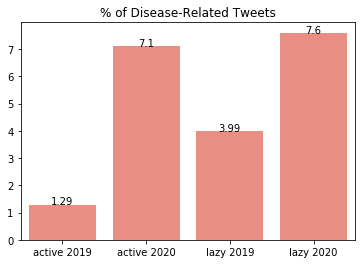

In [9]:
# % of tweets about illness
x = ['active 2019', 'active 2020', 'lazy 2019', 'lazy 2020']
y = [100*len(active19[active19.word_sim>0.55])/len(active19), 
     100*len(active20[active20.word_sim>0.55])/len(active20),
     100*len(lazy19[lazy19.word_sim>0.55])/len(lazy19), 
     100*len(lazy20[lazy20.word_sim>0.55])/len(lazy20)]
abs_vals=[len(active19[active19.word_sim>0.55]),len(active20[active20.word_sim>0.55]),
         len(lazy19[lazy19.word_sim>0.55]),len(lazy20[lazy20.word_sim>0.55])]
g=sns.barplot(x,y, color='salmon')
for i, v in enumerate(y):
    g.text(i,v,round(float(v),2), color='black', ha="center")
_ = plt.title('% of Disease-Related Tweets')
_ = plt.show()

In [10]:
print('YoY Increase in Disease-Related Tweets - Active Users:',abs_vals[1]-abs_vals[0])
print('YoY Increase in Disease-Related Tweets - Lazy Users:',abs_vals[3]-abs_vals[2])

YoY Increase in Disease-Related Tweets - Active Users: 4017
YoY Increase in Disease-Related Tweets - Lazy Users: 3569


There is a YoY increase in disease-related tweets of 5-6% in both groups, which equals to 4K more tweets in 2020 in every user cohort.

In [13]:
# import Disease-Related Tweets dataframes for future use:
active19[active19.word_sim>0.55].to_csv('active19-disease.csv')
active20[active20.word_sim>0.55].to_csv('active20-disease.csv')
lazy19[lazy19.word_sim>0.55].to_csv('lazy19-disease.csv')
lazy20[lazy20.word_sim>0.55].to_csv('lazy20-disease.csv')

## Sentiment Analysis for Disease-Realted Tweets

We will use out-of0-the-box Twitter Sentiment model called SentimentIntensityAnalyzer from vaderSentiment package. The model produces negative, neutral, positive and compound scores. We will follow the thresholds for sentiment determined on the vaderSentiment website:<br>
"The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a ‘normalized, weighted composite score’ is accurate.<br>
It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:<br>
positive sentiment: compound score >= 0.05<br>
neutral sentiment: (compound score > -0.05) and (compound score < 0.05)<br>
negative sentiment: compound score <= -0.05"

### 2019 vs 2020

In [15]:
# comnine active and lazy for 2019 and 2020:
cols=['Text','Date','Name','Location','clean_text','word_sim']
df1 = pd.read_csv('active19_disease.csv', usecols=cols)
df2 = pd.read_csv('lazy19_disease.csv', usecols=cols)
df2019 = pd.concat([df1,df2], axis=0, ignore_index=True)

df3 = pd.read_csv('active20_disease.csv', usecols=cols)
df4 = pd.read_csv('lazy20_disease.csv', usecols=cols)
df2020 = pd.concat([df3,df4], axis=0, ignore_index=True)

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
test = analyzer.polarity_scores('This package is good at identifying sentiment')  #df2019.clean_text[0]
print(test)

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}


In [17]:
pos_count = 0
is_pos = 0
neg_count = 0
is_neg = 0
threshold = 0.05 #using the recommended threshold values

def analyze_sentiment(df):
    pos_count = 0
    is_pos = 0
    neg_count = 0
    is_neg = 0
    threshold = 0.05 #using the recommended threshold values
    for i in range(0, len(df)):
        vs = analyzer.polarity_scores(df.Text[i]) #using Text and not clean text to include all negative stopwords 
        if vs['compound'] >= threshold:
            is_pos +=1
            pos_count +=1
        elif vs['compound'] <= -threshold:
            is_neg +=1
            neg_count +=1
        else:
            continue
    print("Positive accuracy = {}% via {} samples".format(is_pos/(pos_count+neg_count)*100, (pos_count+neg_count)))
    print("Negative accuracy = {}% via {} samples".format(is_neg/(pos_count+neg_count)*100, (pos_count+neg_count)))

In [18]:
analyze_sentiment(df2019)

Positive accuracy = 51.49253731343284% via 134 samples
Negative accuracy = 48.507462686567166% via 134 samples


In [19]:
analyze_sentiment(df2020)

Positive accuracy = 52.523853493382575% via 6498 samples
Negative accuracy = 47.476146506617425% via 6498 samples


2020 to 2019 YoY change in sentiment towards disease was quite small: the positive accuracy increased by 1% from 51.5% to 52.5%. Interestingly, there was slightly more positive sentiment in 2020 during the COVID pandemic.

### Active vs Lazy

In [20]:
# comnine 2019 and 2020 for active and lazy:
cols=['Text','Date','Name','Location','clean_text','word_sim']
df1 = pd.read_csv('active19_disease.csv', usecols=cols)
df2 = pd.read_csv('active20_disease.csv', usecols=cols)
df_active = pd.concat([df1,df2], axis=0, ignore_index=True)

df3 = pd.read_csv('lazy19_disease.csv', usecols=cols)
df4 = pd.read_csv('lazy20_disease.csv', usecols=cols)
df_lazy = pd.concat([df3,df4], axis=0, ignore_index=True)

In [21]:
analyze_sentiment(df_active)

Positive accuracy = 56.83192261185006% via 3308 samples
Negative accuracy = 43.16807738814994% via 3308 samples


In [22]:
analyze_sentiment(df_lazy)

Positive accuracy = 48.194945848375454% via 3324 samples
Negative accuracy = 51.80505415162455% via 3324 samples


Combining both 2019 and 2020 years, users in the active cohort are almost 8% more negative on Twitter about diseases than the users in the lazy cohort.

### Active and Lazy in 2019 vs 2020

We also decided to look at all tweets and compare the sentiment in 2019 and 2020 for both user cohorts. 

In [23]:
analyze_sentiment(active19)

Positive accuracy = 87.20103425985779% via 3094 samples
Negative accuracy = 12.79896574014221% via 3094 samples


In [24]:
analyze_sentiment(active20)

Positive accuracy = 81.74184926498398% via 39659 samples
Negative accuracy = 18.258150735016013% via 39659 samples


In [25]:
analyze_sentiment(lazy19)

Positive accuracy = 70.54794520547945% via 1460 samples
Negative accuracy = 29.45205479452055% via 1460 samples


In [26]:
analyze_sentiment(lazy20)

Positive accuracy = 64.01385182361165% via 31476 samples
Negative accuracy = 35.98614817638836% via 31476 samples


The mood on Twitter in 2020 worsened vs a year ago by 5.5%  for active users, and by 6.5% for lazy users, whcih means that the events of 2020 COVID pandemic affected lazy and active users equally negatively.